In [1]:
!pip uninstall tensorflow tensorflow_gpu protobuf --yes

Uninstalling tensorflow-1.4.0:
  Successfully uninstalled tensorflow-1.4.0
Cannot uninstall requirement tensorflow-gpu, not installed
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install protobuf==3.6.0 tensorflow==1.8.0 tensorflow_gpu==1.8.0 --no-cache-dir

    100% |████████████████████████████████| 7.1MB 26.7MB/s ta 0:00:01
    100% |████████████████████████████████| 49.1MB 76.8MB/s ta 0:00:01    41% |█████████████▎                  | 20.3MB 56.9MB/s eta 0:00:01    72% |███████████████████████         | 35.3MB 67.0MB/s eta 0:00:01    99% |███████████████████████████████▉| 48.8MB 80.0MB/s eta 0:00:01
    100% |████████████████████████████████| 216.3MB 80.4MB/s ta 0:00:01   35% |███████████▍                    | 77.3MB 68.6MB/s eta 0:00:03    45% |██████████████▋                 | 98.5MB 69.7MB/s eta 0:00:02    85% |███████████████████████████▍    | 185.2MB 56.2MB/s eta 0:00:01    95% |██████████████████████████████▋ | 207.0MB 78.7MB/s eta 0:00:01
    100% |████████████████████████████████| 3.1MB 68.5MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 72.0MB/s ta 0:00:01
    100% |████████████████████████████████| 9.3MB 80.9MB/s ta 0:00:01
    100% |████████████████████████████████| 890kB 59.9MB/s ta 0:00:01
  Found existing 

In [1]:
import os
import scipy
import os.path
import logging
import scipy.io
import functools
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.linalg as la
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as norm
from datetime import datetime
%matplotlib inline 

tfd = tf.contrib.distributions
tfn = tf.contrib.rnn
tfl = tf.linalg
dynrnn = tf.nn.dynamic_rnn
bidynrnn = tf.nn.bidirectional_dynamic_rnn

logger = logging.getLogger('BouncingBalls')
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(message)s')

In [247]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softplus(x):
    return np.log(1 + np.exp(x)) + 1e-5

np.random.seed(100) #4, 100
H = 140
A = 0.8 * np.random.randn(H, H)
R = la.expm(A - A.T)
B = 2 * np.random.randn(1, H)
b = 0.5 * np.random.randn(H, 1)
c = 0.5 * np.random.randn(H, 1)
bias_h = np.random.rand(1, H)
d = 0.05 * np.random.randn(H, 1)

np.random.seed(0)
T = 300; N = 10000; training_size = 9000
sigma_c = 5.3
h = np.zeros((N, T + 1, H))
h[:, 0, :] = norm.rvs(mean=None, cov=np.eye(H), size=N)
y = np.zeros((N, T + 1, 1))

for i in range(1, T + 1):
    h[:, i, :] = np.tanh(np.dot(h[:, i - 1, :], R) + np.tanh(np.dot(y[:, i - 1], B))) + 0.7 * h[:, i - 1, :] + bias_h
    y[:, i] = (1.5 * np.dot(h[:, i, :], b) + 1 * np.tanh(np.dot(h[:, i, :], c))
               + 1 * softplus(np.tanh(np.dot(h[:, i, :], d)) - 10) * np.random.randn(N, 1))

y = y[:, 1:]
y = y - np.mean(y)
y_tilde = (y + sigma_c * np.random.randn(N, T, 1))

In [248]:
seq_length = 150
offset = 50
training_data = y_tilde[:training_size, offset:offset+seq_length]
testing_data = y_tilde[training_size:, offset:offset+seq_length]

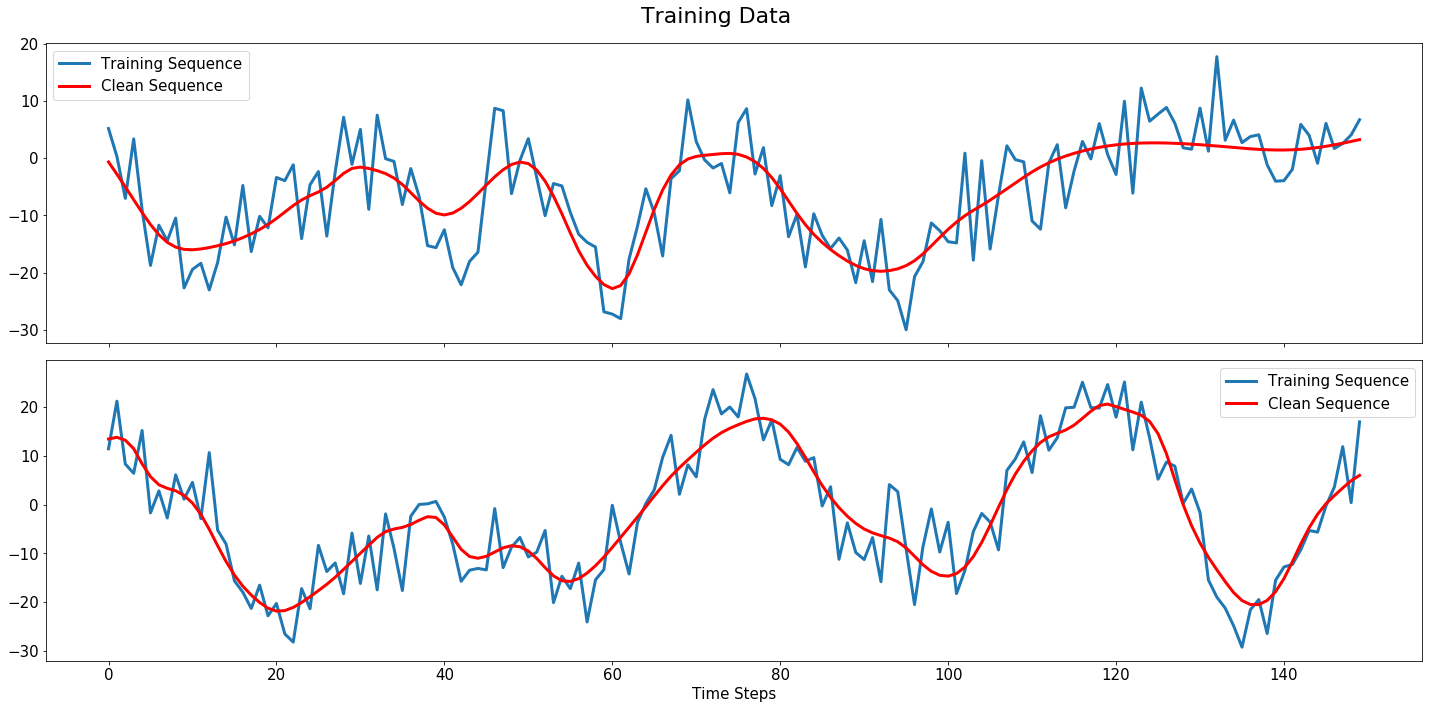

In [249]:
idx = np.random.randint(0, N, 2)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
ax1.plot(y_tilde[idx[0], offset:offset+seq_length], label='Training Sequence', linewidth=3.0)
ax1.plot(y[idx[0], offset:offset+seq_length], 'r', label='Clean Sequence', linewidth=3.0)
ax2.plot(y_tilde[idx[1], offset:offset+seq_length], label='Training Sequence', linewidth=3.0)
ax2.plot(y[idx[1], offset:offset+seq_length], 'r', label='Clean Sequence', linewidth=3.0)
ax2.set_xlabel('Time Steps', fontsize=15)
for ax in (ax1, ax2):
    ax.legend(fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15);
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15);
plt.tight_layout()
plt.subplots_adjust(top=0.93)
fig.suptitle('Training Data', fontsize=22)
# plt.savefig(path + '/training_data.pdf', bbox_inches='tight')
plt.show()

In [18]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [117]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, reg_lambda=0., reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._regulariser = tf.contrib.layers.l2_regularizer(scale=reg_lambda)
        self._layer_mu = tf.layers.Dense(self._event_size, kernel_regularizer=self._regulariser)
        self._layer_sigma = tf.layers.Dense(self._event_size, tf.nn.softplus)

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size, self.state_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        mean = self._layer_mu(hidden)
        std = self._layer_sigma(hidden)
        return (mean, std, hidden), state
    
class GaussianCellWithoutMeans(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, std=None, reuse=None):       
        super(GaussianCellWithoutMeans, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        if std is not None:
            self._std = std[None, None]
        else:
            self._layer_sigma = tf.layers.Dense(self._event_size, tf.nn.softplus)

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self.state_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        try:
            N = inputs.shape[0]
            return (tf.tile(self._std, [N, 1]), hidden), state
        except AttributeError:
            std = self._layer_sigma(hidden)
            return (std, hidden), state
    
class SamplingCell(tf.contrib.rnn.RNNCell):

    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.MultivariateNormalDiag(mean, std).sample()
        return (mean, std, sample), (state, sample)

In [509]:
class RegularisedRobustARGenerator(object):
    """
    Model to test
    """

    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size, dim_z=20, bayesian=True, w_lambda=0., 
                 post_mu_w=None, post_cov_w=None, post_alpha=None, post_beta=None, future_steps=30, **kwargs):
        self._data = data                                               # B x T x D
        self._B = batch_size                                            # B - batch size
        self._T = seq_length                                            # T - number of time steps
        self._D = 1                                                     # D - dimensionality of each time step
        self._N = 9000
        self._Z = dim_z
        self._H = n_hidden                                              # H - dimensionality of RNN hidden states
        self._Sz = n_samples                                            # Sz - number of samples from the posterior
        self._K = future_steps                                          # K - number of future steps for prediction
        self._w_lambda = w_lambda
        
        self._bayesian = bayesian
        self._fixed_sigma = kwargs.get('fixed_sigma', False)
        
        self.initialise_variables                                       #
        
        self.q_z = self.make_posterior_z
        self.q_y = self.make_posterior_y                                # posterior q(y|x)
        
        if self._bayesian:
            mu_w = kwargs.get('mu_w', 0.)
            mu_w = mu_w * tf.ones(self._H)
            sigma_w = tf.convert_to_tensor(kwargs.get('sigma_w', 1.))
            self.p_w = tfd.MultivariateNormalDiag(mu_w, scale_identity_multiplier=tf.sqrt(sigma_w))
            
#             self._post_mu_w = post_mu_w
#             self._post_sigma_w = post_cov_w
            
#             self._post_mu_w = tf.get_variable(shape=(self._H), name='post_mean_w', 
#                                               initializer=tf.constant_initializer(0.))

#             self._post_sigma_w = tf.get_variable(shape=(self._H * (self._H + 1) // 2), name='post_covariance_w', 
#                                                  initializer=tf.constant_initializer(kwargs.get('sigma_w', 1.)))

            post_mu_w = mu_w = kwargs.get('mu_w', 0.)
#             self._post_mu_w = post_mu_w * tf.ones(self._H)
            post_sigma_w = kwargs.get('sigma_w', 1.)
#             self._post_sigma_w = post_sigma_w * tf.eye(self._H)
            
            self._post_mu_w = tf.get_variable(shape=(self._H), name='post_mean_w', 
                                              initializer=tf.constant_initializer(post_mean_w * np.ones(self._H)))
            self._post_sigma_w = tf.get_variable(shape=(self._H, self._H), name='post_covariance_w',
                                     initializer=tf.constant_initializer(np.sqrt(post_sigma_w) * np.eye(self._H)))
            
            alpha = tf.convert_to_tensor(kwargs.get('alpha', 1.5))
            beta = tf.convert_to_tensor(kwargs.get('beta', 60.))
            self.p_sigma = tfd.InverseGamma(alpha, beta)
            
            self._post_alpha = post_alpha
            self._post_beta = post_beta
            
            print('Variational Bayes with priors mu_w = {}, sigma_w = {}, alpha = {}, beta = {}'
                  .format(kwargs.get('mu_w', 0.), kwargs.get('sigma_w', 1.), kwargs.get('alpha', 1.5), 
                          kwargs.get('beta', 60.)))
            
        self.p_y = self.make_transitional                               # prior p(y|z) under q(z) and q(y)        
        self.make_reconstruction
        self.compute_elbo
        
        self.E_step
        self.M_step

    @define_scope
    def initialise_variables(self):
        # Initialises all variables and RNN cells
        self._cell = tfn.GRUBlockCell(self._H)        
        if self._w_lambda > 0. or self._bayesian is False:
            self._gauss_cell = GaussianCell(self._cell, self._D, reg_lambda=self._w_lambda)
        else:
            self._trans_std = tf.nn.softplus(tf.get_variable(shape=(), name='trans_std', 
                                               initializer=tf.constant_initializer(1))) + 1e-5
            self._mean_bias = tf.get_variable(shape=(), name='means_bias', initializer=tf.constant_initializer(0.))
            self._gauss_cell = GaussianCellWithoutMeans(self._cell, self._D, self._trans_std)
                                      
        self._sampling_cell = SamplingCell(self._gauss_cell, self._D)
        
        self._post_cell_z = tfn.GRUBlockCell(self._H)
        self._layer_z = tf.layers.Dense(self._H, tf.nn.relu)
        
        self._post_cell_f = tfn.GRUBlockCell(self._H)
        self._post_cell_b = tfn.GRUBlockCell(self._H)
        self._post_layer_means = tf.layers.Dense(self._D)
        self._post_layer_stds = tf.layers.Dense(self._D, tf.nn.softplus)
        
        self._most_likely_pred = tf.get_variable(shape=(1, self._K, self._D), name='best_forward_sequence',
                                                 initializer=tf.constant_initializer(0))
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self._optimiser_forward = tf.train.AdamOptimizer(0.001)
    
    @define_scope
    def make_posterior_z(self):
        _, h = dynrnn(self._post_cell_z, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus) + 1e-5
        posterior_z = tfd.MultivariateNormalDiag(means, stds)
        return posterior_z

    @define_scope
    def make_kl_z(self):
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(self.q_z, p))
    
    @define_scope
    def make_posterior_y(self):
        (out_f, out_b), _ = bidynrnn(self._post_cell_f, self._post_cell_b, inputs=self._data, dtype=tf.float32)
        hidden = tf.concat([out_f, out_b], 2)
        self._post_means = self._post_layer_means(hidden)
        self._post_stds = self._post_layer_stds(hidden) + 1e-5
        return tfd.MultivariateNormalDiag(self._post_means, self._post_stds)

    @define_scope
    def make_transitional(self):
        self._code_z = self.q_z.sample(self._Sz)
        self._code_y = self.q_y.sample(self._Sz)
        code_y = tf.reshape(self._code_y, [-1, self._T, self._D])
        hidden = self._layer_z(tf.reshape(self._code_z, [-1, self._Z]))
        inputs = tf.concat([tf.zeros((self._B * self._Sz, 1, self._D)), code_y[:, :-1]], 1)
        if self._w_lambda > 0. or self._bayesian is False:
            (_, _, _), _ = self._gauss_cell(tf.zeros((self._B * self._Sz, self._D)), 
                                            tf.zeros((self._B * self._Sz, self._H)))
            (means, self._trans_stds, self._hiddens), _ = dynrnn(self._gauss_cell, 
                                                                 inputs=inputs, initial_state=hidden)
            means = tf.reshape(means, [self._Sz, self._B, self._T, self._D])
            stds = tf.reshape(self._trans_stds, [self._Sz, self._B, self._T, self._D])
        else:
            (self._trans_stds, self._hiddens), _ = dynrnn(self._gauss_cell, inputs=inputs, initial_state=hidden)
            hiddens = tf.reshape(self._hiddens, [self._Sz, self._B, self._T, self._H])
            hiddens = tf.tile(hiddens[None, ...], [self._Sz, 1, 1, 1, 1])
            W = tfd.MultivariateNormalFullCovariance(loc=self._post_mu_w, 
                                                     covariance_matrix=self._post_sigma_w).sample(self._Sz)
            
            means = tf.einsum('ijklm,im->ijkl', hiddens, W) + self._mean_bias
            stds = tf.reshape(self._trans_stds, [self._Sz, self._B, self._T, self._D])
            stds = tf.tile(stds[None, ...], [self._Sz, 1, 1, 1, 1])
#             means = tf.tensordot(hiddens, self._W[:, None], 1) + self._mean_bias 
        return tfd.MultivariateNormalDiag(means[..., None], stds)

    @define_scope
    def make_kl_y(self):
        kl = tf.reduce_sum(tfd.kl_divergence(self.q_y, self.p_y)) / self._Sz
        if self._w_lambda > 0. or self._bayesian is False:
            return kl
        else:
            return kl / self._Sz

    @define_scope
    def make_reconstruction(self):
        data = tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1))
        mean = self._code_y
        if self._fixed_sigma:
            self._gen_std = tf.nn.softplus(tf.get_variable(shape=(), name='gen_std', trainable=False,
                                           initializer=tf.constant_initializer(5.3))) + 1e-5
            gen_prob = tfd.MultivariateNormalDiag(mean, scale_identity_multiplier=self._gen_std)
            
        else:
            if bayesian:
                sigma = tfd.InverseGamma(self._post_alpha, self._post_beta).sample(self._Sz)
                sigma = sigma[:, None, None]
                gen_prob = tfd.MultivariateNormalDiag(mean, scale_identity_multiplier=tf.sqrt(sigma))
            else:
                self._gen_std = tf.nn.softplus(tf.get_variable(shape=(), name='gen_std', 
                                               initializer=tf.constant_initializer(1))) + 1e-5
                gen_prob = tfd.MultivariateNormalDiag(mean, scale_identity_multiplier=self._gen_std)
            
        return tf.reduce_sum(gen_prob.log_prob(data)) / self._Sz
    
    @define_scope
    def compute_elbo(self):
        kl_z = self.make_kl_z
        kl_y = self.make_kl_y
        reconstruction = self.make_reconstruction
        if self._w_lambda == 0.:
            loss = reconstruction - kl_z - kl_y 
        else:
            l2_loss = tf.losses.get_regularization_loss()
            loss = reconstruction - kl_z - kl_y - l2_loss        
        return loss, kl_z, kl_y, reconstruction
        
    @define_scope
    def E_step(self):
        # Optimses the ELBO function
        vars_e = [v for v in tf.trainable_variables() if 'make_posterior' in v.name]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0], var_list=vars_e))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def M_step(self):
        # Optimses the ELBO function
        vars_m = [v for v in tf.trainable_variables() if 'make_posterior' not in v.name]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0], var_list=vars_m))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def bayesian_update_W(self):
        scaling = self._N / self._B 
        
        code_y = tf.reshape(self._code_y, [-1, self._T, self._D])
        hidden = self._layer_z(tf.reshape(self._code_z, [-1, self._Z]))
        inputs = tf.concat([tf.zeros((self._B * self._Sz, 1, self._D)), code_y[:, :-1]], 1)
        (trans_stds, hiddens), _ = dynrnn(self._gauss_cell, inputs=inputs, initial_state=hidden)
        
        data_precision = tf.diag(tf.reduce_sum(tf.square(hiddens/trans_stds), [0, 1])) / self._Sz
        post_precision = tf.matrix_inverse(self.p_w.covariance()) + data_precision * scaling
        post_covariance = tf.matrix_inverse(post_precision)
        first_order = tf.reshape(hiddens / np.square(trans_stds), [self._Sz, self._B, self._T, self._H])
        first_order = tf.reduce_mean(first_order * self._code_y, 0)
        first_order = tf.reduce_sum(first_order, [0, 1])
        post_mean = tf.tensordot(post_covariance, scaling * first_order, 1)
        tf.assign(self._post_mu_w, post_mean) 
        tf.assign(self._post_sigma_w, post_covariance)
        return post_mean

In [505]:
def bayesian_update_w(sess, model, N, S, B, T, H, batch):
    prior_mean, prior_covariance, hiddens, trans_stds, code_y = \
        sess.run([model.p_w.mean(), model.p_w.covariance(), model._hiddens, model._trans_stds, 
                  model._code_y], {x_: batch})
    scaling = N / B 
    
    data_precision = np.diag(np.sum(np.square(hiddens/trans_stds), (0, 1))) / S
    post_precision = np.linalg.inv(prior_covariance) + data_precision * scaling
    post_covariance = np.linalg.inv(post_precision)
    first_order = np.reshape(hiddens / np.square(trans_stds), (S, B, T, H))
    first_order = np.mean(first_order * code_y, 0)
    first_order = np.sum(first_order, axis=(0, 1))
    post_mean = np.matmul(post_covariance, scaling * first_order)
    return post_mean, post_covariance

def bayesian_update_sigma(sess, model, N, B, T, batch):
    prior_alpha, prior_beta, post_means, post_stds = \
        sess.run([model.p_sigma.concentration, model.p_sigma.rate, model._post_means, model._post_stds], {x_: batch})
    scaling = N / B

    post_alpha = prior_alpha + (B * T) * scaling / 2
    post_beta = np.square(batch)  + (np.square(post_means) + np.square(post_stds)) -2 * batch * post_means
    post_beta = prior_beta + np.sum(post_beta) * scaling / 2
    return post_alpha, post_beta

In [514]:
tf.reset_default_graph()
S = 20
B = 20 
T = 100 
I = 20000
H = 50
K = 5
Z = 20
w_lambda = 0.

bayesian = True
post_mean_w = np.zeros((H))
post_cov_w = np.eye(H)
post_alpha = 20
post_beta = 160

model_name = 'H_{}_B_{}_T_{}_Z_{}'.format(H, B, T, Z)
if w_lambda != 0.:
    model_name += '_w_lambda_{}'.format(w_lambda)
path = './mean_field_{}'.format(model_name)
if bayesian:
    path = './bayesian_mean_field_{}'.format(model_name)
train = True
print_every = 1000
save_every = 100
plot = True
restore = False
restore_forward = False
predict = False

os.makedirs(path, exist_ok=True)
os.makedirs(path + '/ckpt', exist_ok=True)
os.makedirs(path + '/training_curves', exist_ok=True)

if train:
    log_fh = logging.FileHandler(os.path.join(path, '{}.log'.format(datetime.now().strftime('%Y-%m-%d_%H:%M:%S'))))
    log_fh.setFormatter(formatter)
    logger.addHandler(log_fh)

logger.info('Experimental setup:')
logger.info('B = {}, S = {}, T = {}, H = {}, Z = {}, I = {}, N = {}'.format(B, S, T, H, Z, I, training_data.shape[0]))
if bayesian:
    logger.info('Variational Bayes with default parameters')

x_ = tf.placeholder(tf.float32, [B, T, 1])
mu_w_ = tf.placeholder(tf.float32, [H])
sigma_w_ = tf.placeholder(tf.float32, [H, H])
alpha_ = tf.placeholder(tf.float32, [])
beta_ = tf.placeholder(tf.float32, [])

gen_model = RegularisedRobustARGenerator(x_, n_hidden=H, n_samples=S, seq_length=T, batch_size=B, bayesian=bayesian, 
                                         post_mu_w=mu_w_, post_cov_w=sigma_w_, w_lambda=w_lambda, post_alpha=alpha_,
                                         post_beta=beta_, 
                                         **{'mu_w': 0., 'sigma_w': 1e10, 'alpha': 20., 'beta': 160.})

sess = tf.Session()
saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' not in v.name])
forw_saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' in v.name])

if restore:
    try:
        saver.restore(sess, path + '/ckpt/modelling.ckpt')
        sess.run(tf.variables_initializer([v for v in tf.global_variables() if 'forward' in v.name]))
        logger.info('Model parameters loaded successfully.')
        
    except tf.errors.NotFoundError as e:
        logger.warning('No model to load. Run simulation without initialisation.')
        sess.run(tf.global_variables_initializer())
    
    try:
        elbos = np.load(os.path.join(path + '/training_curves/elbos.npy')).tolist()
        llks = np.load(os.path.join(path + '/training_curves/llks.npy')).tolist()
        kls_z = np.load(os.path.join(path + '/training_curves/kls_z.npy')).tolist()
        kls_y = np.load(os.path.join(path + '/training_curves/kls_y.npy')).tolist()
        test_elbos = np.load(os.path.join(path + '/training_curves/test_elbos.npy')).tolist()
        logger.info('Training curves loaded successfully.')
        
    except FileNotFoundError as e:
        logger.info('No training curves to restore.')
        
else:
    sess.run(tf.global_variables_initializer())

logger.info('\n-------------------\n')
if train:
    logger.info('Start training...')
    elbos = []; kls_z = []; kls_y = []; llks = []; test_elbos = []
    
    try:
        for i in range(I):
            idx = np.random.randint(0, training_data.shape[0], B)
            batch = training_data[idx, :T]

            elbo, kl_z, kl_y, llk = sess.run(gen_model.compute_elbo, {x_: batch, mu_w_: post_mean_w, beta_: post_beta,
                                                                      sigma_w_: post_cov_w, alpha_: post_alpha})
            elbos.append(elbo); kls_z.append(kl_z); kls_y.append(kl_y); llks.append(llk)
            
            if i % 10 == 0:
                test_idx = np.random.randint(0, testing_data.shape[0], B)
                test_batch = testing_data[test_idx, :T]
                test_elbo, _, _, _ = sess.run(gen_model.compute_elbo, {x_: test_batch, mu_w_: post_mean_w, 
                                                                       sigma_w_: post_cov_w, alpha_: post_alpha, 
                                                                       beta_: post_beta})
                test_elbos.append(test_elbo)

            if i % print_every == 0:
                logger.info(
    '''Iteration: {}, ELBO: {:.2f}, KL (z): {:.2f}, KL (y): {:.2f}, Reconstruction: {:.2f}, Test ELBO: {:.2f}'''
                    .format(i, elbo, kl_z, kl_y, llk, test_elbo))
                print(
    '''Iteration: {}, ELBO: {:.2f}, KL (z): {:.2f}, KL (y): {:.2f}, Reconstruction: {:.2f}, Test ELBO: {:.2f}'''
                    .format(i, elbo, kl_z, kl_y, llk, test_elbo))
                
            if i % save_every == 0:
                saver.save(sess, path + '/ckpt/modelling.ckpt')
                np.save(os.path.join(path + '/training_curves/elbos.npy'), np.stack(elbos))
                np.save(os.path.join(path + '/training_curves/llks.npy'), np.stack(llks))
                np.save(os.path.join(path + '/training_curves/kls_z.npy'), np.stack(kls_z))
                np.save(os.path.join(path + '/training_curves/kls_y.npy'), np.stack(kls_y))
                np.save(os.path.join(path + '/training_curves/test_elbos.npy'), np.stack(test_elbos))
            
            sess.run(gen_model.E_step, {x_: batch, mu_w_: post_mean_w, sigma_w_: post_cov_w, 
                                        alpha_: post_alpha, beta_: post_beta})
            sess.run(gen_model.M_step, {x_: batch, mu_w_: post_mean_w, sigma_w_: post_cov_w,
                                        alpha_: post_alpha, beta_: post_beta})
            
            if bayesian and i > 0 and i % 5 == 0:
                (post_alpha, post_beta) = bayesian_update_sigma(sess, gen_model, training_data.shape[0], B, T, batch)
                sess.run(gen_model.bayesian_update_W, {x_: batch})
#                 (post_mean_w, post_cov_w) =  bayesian_update_w(sess, gen_model, training_data.shape[0], 
#                                                                S, B, T, H, batch)
    
    except KeyboardInterrupt as e:
        logger.warning('Training interrupted at iteration {}.'.format(i))
    
    logger.info('Training Complete.')
    
    saver.save(sess, path + '/ckpt/modelling.ckpt')
    logger.info('Model parameters saved successfully.')
    
    np.save(os.path.join(path + '/training_curves/elbos.npy'), np.stack(elbos))
    np.save(os.path.join(path + '/training_curves/llks.npy'), np.stack(llks))
    np.save(os.path.join(path + '/training_curves/kls_z.npy'), np.stack(kls_z))
    np.save(os.path.join(path + '/training_curves/kls_y.npy'), np.stack(kls_y))
    np.save(os.path.join(path + '/training_curves/test_elbos.npy'), np.stack(test_elbos))
    logger.info('Training curves saved successfully.')

Variational Bayes with priors mu_w = 0.0, sigma_w = 10000000000.0, alpha = 20.0, beta = 160.0
Iteration: 0, ELBO: -73081760.00, KL (z): 188.33, KL (y): 73064648.00, Reconstruction: -16921.55, Test ELBO: -112118816.00
Iteration: 1000, ELBO: -15660.47, KL (z): 527.35, KL (y): 7185.69, Reconstruction: -7947.43, Test ELBO: -15458.10
Iteration: 2000, ELBO: -9654.79, KL (z): 405.07, KL (y): 1344.31, Reconstruction: -7905.42, Test ELBO: -9479.67
Iteration: 3000, ELBO: -8853.68, KL (z): 248.69, KL (y): 961.13, Reconstruction: -7643.86, Test ELBO: -8444.01
Iteration: 4000, ELBO: -9124.03, KL (z): 160.78, KL (y): 1426.94, Reconstruction: -7536.31, Test ELBO: -9099.42
Iteration: 5000, ELBO: -8544.43, KL (z): 100.24, KL (y): 688.77, Reconstruction: -7755.42, Test ELBO: -8138.67
Iteration: 6000, ELBO: -8109.05, KL (z): 56.06, KL (y): 443.73, Reconstruction: -7609.26, Test ELBO: -8139.29
Iteration: 7000, ELBO: -8003.56, KL (z): 27.77, KL (y): 328.48, Reconstruction: -7647.31, Test ELBO: -8036.51
Ite

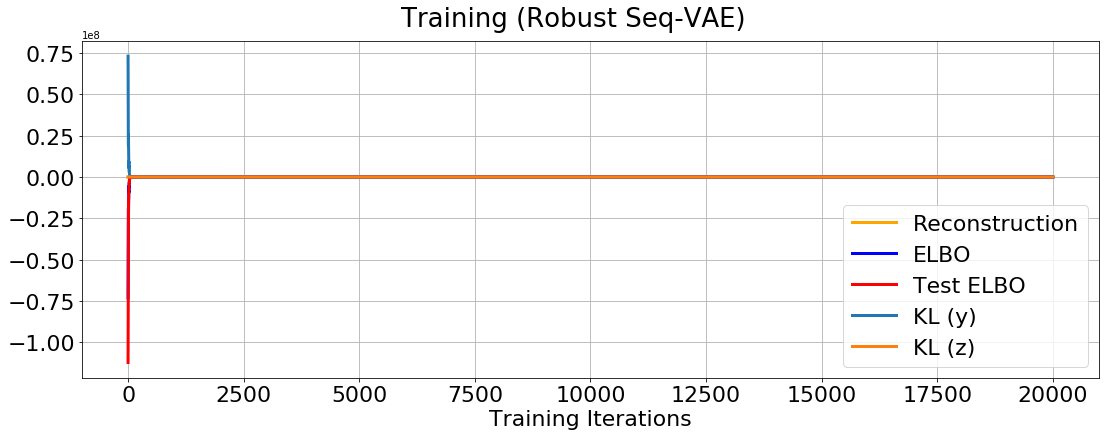

In [515]:
if plot:
    fig, ax = plt.subplots(1, 1, figsize=(15,6))    
    plt.plot(llks, 'orange', label='Reconstruction', linewidth=3.0)
    plt.plot(elbos, 'b', label='ELBO', linewidth=3.0)
    plt.plot([10 * i for i in range(len(test_elbos))], test_elbos, 'r', label='Test ELBO', linewidth=3.0)
    plt.plot(kls_y, label='KL (y)', linewidth=3.0)
    plt.plot(kls_z, label='KL (z)', linewidth=3.0)
    ax.set_xlabel('Training Iterations', fontsize=22)
#     plt.ylim([-80000, 10000])
    plt.grid("on")
    plt.legend(fontsize=22)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    fig.suptitle('Training (Robust Seq-VAE)', fontsize=26)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(22);
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(22);
#     plt.savefig(path + '/training_curve_robust_new.pdf', bbox_inches='tight')
    plt.show()

In [516]:
np.random.seed(0)
idx = np.random.randint(0, testing_data.shape[0], B)
test_batch = testing_data[idx, :T]
prior_means = sess.run(gen_model.p_y.mean(), {x_: test_batch, mu_w_: post_mean_w, sigma_w_: post_cov_w})
post_means = sess.run(gen_model.q_y.mean(), {x_: test_batch, mu_w_: post_mean_w, sigma_w_: post_cov_w})
latents = sess.run(gen_model._code_y, {x_: test_batch, mu_w_: post_mean_w, sigma_w_: post_cov_w})

ValueError: x and y can be no greater than 2-D, but have shapes (20,) and (20, 100, 1)

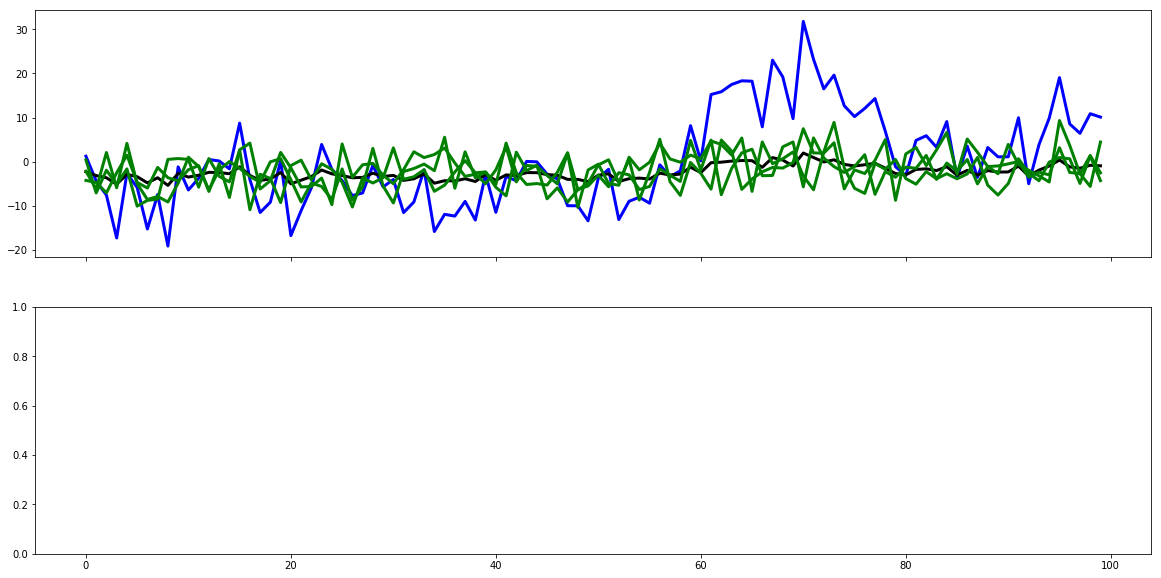

In [517]:
if True:
    plot_idx = np.random.choice(B, 2, replace=False)
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20,10))

    for e, ax in enumerate(axs.flatten()):
        ax.plot(test_batch[plot_idx[e], :], 'b', label='Noisy Sequence', linewidth=3.0)
        ax.plot(np.reshape(post_means, (B, T))[plot_idx[e]], 'k', label='Posterior Mean', linewidth=3.0)
        ax.plot(np.reshape(latents, (S, B, T))[0, plot_idx[e]] , 'g', label='Posterior Sample', linewidth=3.0)
        ax.plot(np.reshape(latents, (S, B, T))[1, plot_idx[e]] , 'g', linewidth=3.0)
        ax.plot(np.reshape(latents, (S, B, T))[2, plot_idx[e]] , 'g', linewidth=3.0)
        ax.plot(prior_means[0, plot_idx[e]] , 'r', label='Prior Mean', linewidth=3.0)
        ax.plot(prior_means[1, plot_idx[e]] , 'r', linewidth=3.0)
        ax.plot(prior_means[2, plot_idx[e]] , 'r', linewidth=3.0)
        ax.plot(prior_means[3, plot_idx[e]] , 'r', linewidth=3.0)
        ax.plot([], [])
        ax.plot(y[training_size:][idx[plot_idx[e]], offset:T+offset], label='Clean Signal', linewidth=3.0)
        ax.legend(fontsize=22)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(22);
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(22);
    axs[-1].set_xlabel('Time Steps', fontsize=22)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    fig.suptitle('Robust Seq-VAE (Mean Field) using MAP (Fixed true $\sigma$, $\lambda=5$)', fontsize=30)
#     plt.savefig(path + '/modelling.pdf', bbox_inches='tight')
    plt.show()

In [472]:
sess.run(gen_model._post_mu_w)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [20,100,1]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[20,100,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: bayesian_update_W/Tensordot/_421 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_524_bayesian_update_W/Tensordot", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder', defined at:
  File "/opt/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/miniconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-467-af8852884e3b>", line 45, in <module>
    x_ = tf.placeholder(tf.float32, [B, T, 1])
  File "/opt/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/opt/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/opt/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/opt/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [20,100,1]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[20,100,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: bayesian_update_W/Tensordot/_421 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_524_bayesian_update_W/Tensordot", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [420]:
sess.run(gen_model._W, {mu_w_: post_mean_w, sigma_w_: post_cov_w})

array([-0.43160236,  0.03305962, -0.410184  , -1.01397049,  0.0832235 ,
       -0.64571744, -0.95337188,  0.36402634,  0.0056638 , -0.52452093,
        0.92661321, -1.14320672, -0.00863031, -1.48103273, -0.45285341,
       -0.21208805,  0.63700873,  1.02898324, -0.47596234, -0.59842646,
       -0.04301759,  1.81180596,  0.04915579,  1.143296  , -0.88856024,
       -0.6016193 ,  0.7281425 ,  0.72815347,  0.43427274, -0.65789717,
        2.12673402,  0.03234381, -0.47197384, -0.44923031,  0.0406566 ,
       -1.12302315, -1.17406952,  0.48593682, -0.12052174,  1.40093434,
        0.63857687,  1.08427954,  1.28957653,  0.63862479,  0.9597618 ,
       -1.08667266, -1.80058312,  0.29662448, -0.70079178,  2.52259064], dtype=float32)

In [429]:
sess.run(tfd.InverseGamma(20., 160.).sample(10))

array([  7.59392548,   7.95689297,   9.76655006,   7.58715391,
        12.43340111,   8.90813446,   6.79960585,   8.4999876 ,
        13.45129204,  10.39676762], dtype=float32)

In [430]:
sess.run(tfd.InverseGamma(gen_model._post_alpha, gen_model._post_beta).sample(10), 
         {alpha_: post_alpha, beta_: post_beta})

array([ 47.26730728,  47.49492645,  47.36156464,  47.35641098,
        47.40885544,  47.2220726 ,  47.2195549 ,  47.19680786,
        47.29356003,  47.299263  ], dtype=float32)

In [373]:
np.random.seed(1)
idx = np.random.randint(0, testing_data.shape[0], B)
test_batch = testing_data[idx, :T]

In [113]:
if restore_forward:
    try:
        forw_saver.restore(sess, path + '/ckpt/prediction.ckpt')        
    except tf.errors.NotFoundError:
        print('No forward prediction variables to load!')
    
    try:
        elbos_forward = np.load(os.path.join(path + '/training_curves/elbos_forward.npy')).tolist()
        llks_x_forward = np.load(os.path.join(path + '/training_curves/llks_x_forward.npy')).tolist()
        llks_y_forward = np.load(os.path.join(path + '/training_curves/llks_y_forward.npy')).tolist()
        kls_y_forward = np.load(os.path.join(path + '/training_curves/kls_y_forward.npy')).tolist()
        
    except FileNotFoundError as e:
        print('No forward prediction training curves to restore')
        elbos_forward = []
        llks_x_forward = []
        llks_y_forward = []
        kls_y_forward = []

else:
    elbos_forward = []
    llks_x_forward = []
    llks_y_forward = []
    kls_y_forward = []
    
if predict:
    for i in range(500):
        elbo_f, llk_x_f, llk_y_f, kl_y_f = sess.run(gen_model.compute_elbo_forward, {x_: test_batch[9:10]})
        
        elbos_forward.append(elbo_f)
        llks_x_forward.append(llk_x_f)
        llks_y_forward.append(llk_y_f)
        kls_y_forward.append(kl_y_f)
        
        if i % 10 == 0:
            print('Iteration:', i, 'ELBO Forward:', elbo_f)
        
        for _ in range(1):
            sess.run(gen_model.E_step_forward, {x_: test_batch[9:10]})
        for _ in range(100):
            sess.run(gen_model.M_step_forward, {x_: test_batch[9:10]})
            
        if i % 50 == 0:
            forw_saver.save(sess, path + '/ckpt/prediction.ckpt')
            np.save(os.path.join(path + '/training_curves/elbos_forward.npy'), np.stack(elbos_forward))
            np.save(os.path.join(path + '/training_curves/llks_x_forward.npy'), np.stack(llks_x_forward))
            np.save(os.path.join(path + '/training_curves/llks_y_forward.npy'), np.stack(llks_y_forward))
            np.save(os.path.join(path + '/training_curves/kls_y_forward.npy'), np.stack(kls_y_forward))
            
    forw_saver.save(sess, path + '/ckpt/prediction.ckpt')
    np.save(os.path.join(path + '/training_curves/elbos_forward.npy'), np.stack(elbos_forward))
    np.save(os.path.join(path + '/training_curves/llks_x_forward.npy'), np.stack(llks_x_forward))
    np.save(os.path.join(path + '/training_curves/llks_y_forward.npy'), np.stack(llks_y_forward))
    np.save(os.path.join(path + '/training_curves/kls_y_forward.npy'), np.stack(kls_y_forward))

Iteration: 0 ELBO Forward: -5981.33
Iteration: 10 ELBO Forward: -3466.44
Iteration: 20 ELBO Forward: -1556.74
Iteration: 30 ELBO Forward: -1108.94
Iteration: 40 ELBO Forward: -973.326
Iteration: 50 ELBO Forward: -933.44
Iteration: 60 ELBO Forward: -929.085
Iteration: 70 ELBO Forward: -926.102
Iteration: 80 ELBO Forward: -924.626
Iteration: 90 ELBO Forward: -923.391
Iteration: 100 ELBO Forward: -922.997
Iteration: 110 ELBO Forward: -926.087
Iteration: 120 ELBO Forward: -927.481
Iteration: 130 ELBO Forward: -928.039


KeyboardInterrupt: 

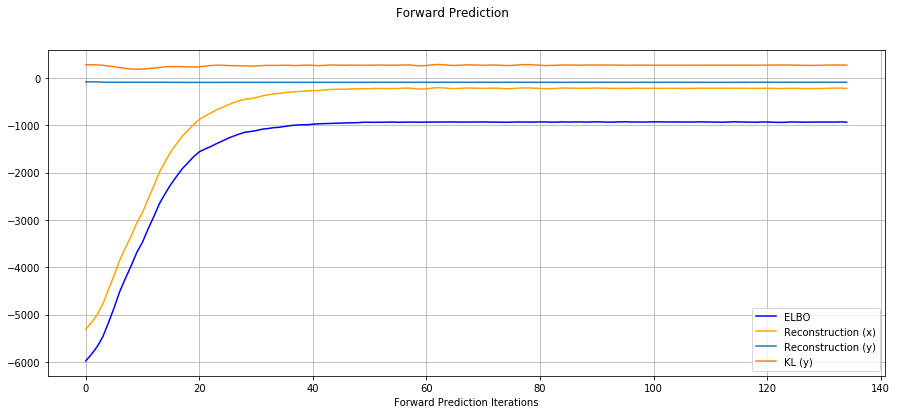

In [114]:
if True:
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    plt.plot(elbos_forward, 'b', label='ELBO')
    plt.plot(llks_x_forward, 'orange', label='Reconstruction (x)')
    plt.plot(llks_y_forward, label='Reconstruction (y)')
    plt.plot(kls_y_forward, label='KL (y)')
    plt.suptitle('Forward Prediction')
    ax.set_xlabel('Forward Prediction Iterations')
    plt.grid("on")
    plt.legend();

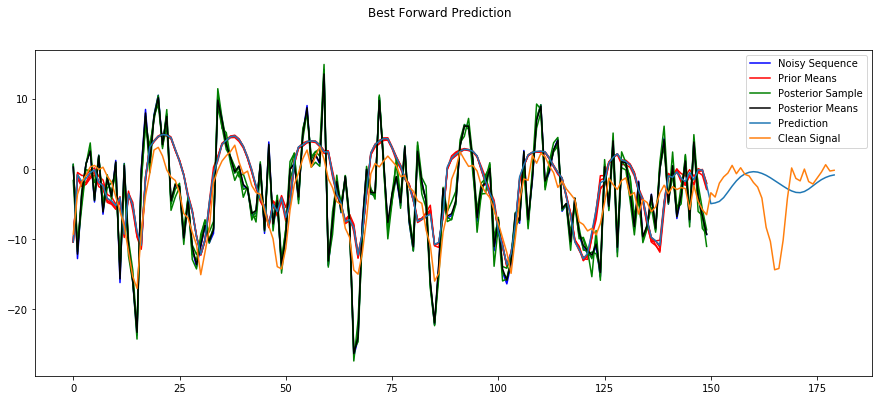

In [115]:
i = 9
latents = sess.run(gen_model._code_y_forw, {x_: test_batch[9:10]})
prior_means = sess.run(gen_model.p_y_forw.mean(), {x_: test_batch[9:10]})
post_means = sess.run(gen_model.q_psi_y.mean(), {x_: test_batch[9:10]})

continuation = sess.run(gen_model._most_likely_pred, {x_: test_batch[9:10]})
if True:
    fig, axs = plt.subplots(1,1,figsize=(15, 6))
    plt.plot(test_batch[i, :], 'b', label='Noisy Sequence')
    plt.plot(prior_means[0], 'r-', label='Prior Means')
    plt.plot(prior_means[1], 'r-')
    plt.plot(prior_means[2], 'r-')
    plt.plot(prior_means[3], 'r-')
    plt.plot(np.reshape(latents, (S, 1, T))[1, 0] , 'g', label='Posterior Sample')
    plt.plot(np.reshape(latents, (S, 1, T))[0, 0] , 'g')
    plt.plot(np.reshape(latents, (S, 1, T))[2, 0] , 'g')
    plt.plot(post_means[0], 'k', label='Posterior Means')
    plt.plot(np.concatenate([np.mean(prior_means, 0), continuation[0]], 0), label='Prediction')
    plt.plot(y[training_size:][idx[i], :T+30], label='Clean Signal')
    plt.legend()
    plt.suptitle("Best Forward Prediction");